# Modelos Tradicionais (Baseline)

In [2]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import torch
from chronos import BaseChronosPipeline
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from datetime import timedelta
from pandas import IndexSlice as idx

C:\Users\Alice Dias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###### Carregar e preparar o dataset

In [11]:
# Abrir o ficheiro
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

In [12]:
# Filtrar CP 2840 e ordenar
df_cp = df[df["ZipCode"] == "2840"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Colocar o item_id obrigatório para o AutoGluon
df_cp["item_id"] = "2840"
df_cp.set_index("DateTime", inplace=True)

###### Separar treino e teste (até 29-09) e teste (30-09)

In [13]:
treino = df_cp.loc[:'2023-09-29 23:00'].copy() # Treino até 29-09-2023 23:00
teste = df_cp.loc['2023-09-30 00:00':'2023-09-30 23:00'].copy() # Teste apenas para validação visual

treino_reset = treino.reset_index() # Reset index para usar com AutoGluon

###### Criar TimeSeriesDataFrame

In [16]:
train_data = TimeSeriesDataFrame.from_data_frame(
    treino_reset[["item_id", "DateTime", "EnergyNormalized"]],
    id_column="item_id",
    timestamp_column="DateTime"
)

# 📊ARIMA

###### importar modelo

In [ ]:
model_path = "AutogluonModels/ag-20250417_182601" # Caminho onde o modelo foi guardado

predictor = TimeSeriesPredictor.load(model_path) # Carregar o modelo

###### treinar

In [47]:
predictor = TimeSeriesPredictor(
    prediction_length=24,
    target="EnergyNormalized",
    eval_metric="MASE"
)

predictor.fit(
    train_data,
    presets="fast_training",
    hyperparameters={"ARIMA": {}},  # apenas ARIMA
    time_limit=300
)

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\AutogluonModels\ag-20250417_185656'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       4.20 GB / 15.93 GB (26.3%)
Disk Space Avail:   717.29 GB / 931.46 GB (77.0%)
Setting presets to: fast_training

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'ARIMA': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'EnergyNormalized',
 'time_limit': 300,
 'verbosity': 2}

Inferred time series frequency: 'h'

###### prever

In [48]:
forecast = predictor.predict(train_data)
forecast_values = forecast.loc["2840"]

# Lidar com possíveis múltiplas colunas
if isinstance(forecast_values, pd.DataFrame):
    y_pred = forecast_values.iloc[:, 0].values
else:
    y_pred = forecast_values.values

Model not specified in predict, will default to the model with the best validation score: ARIMA


###### Preparar dados reais

In [49]:
real_values = teste["EnergyNormalized"]
y_true = real_values.values

###### grafico

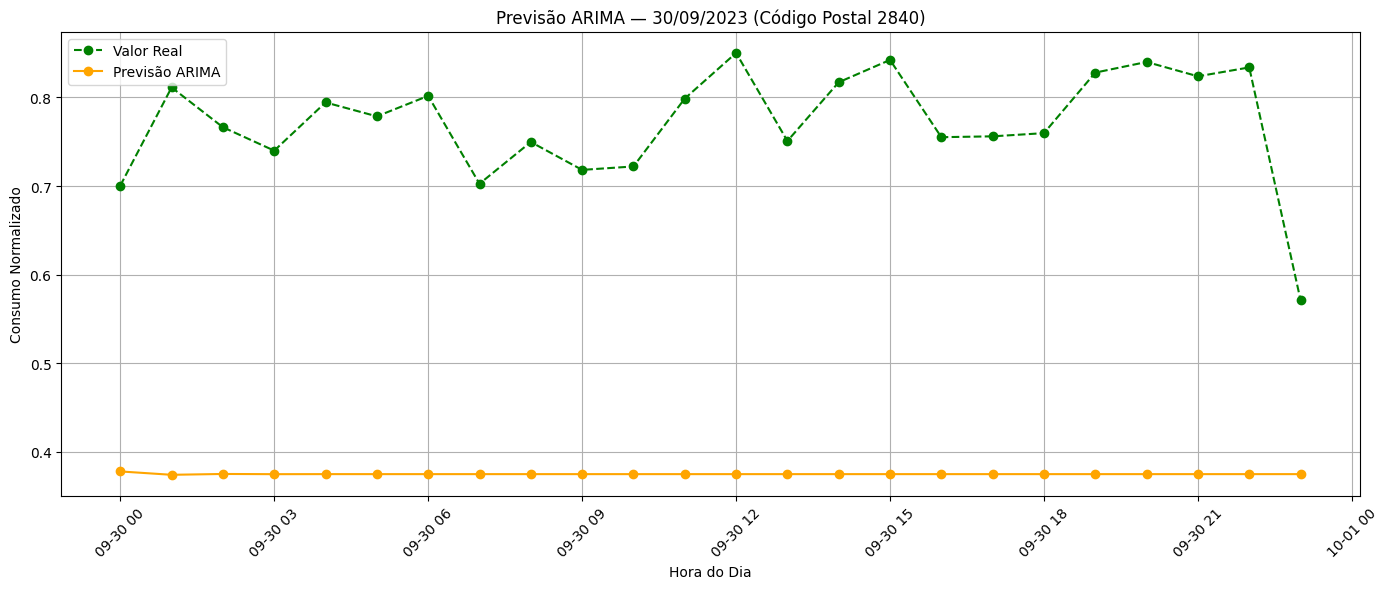

In [50]:
plt.figure(figsize=(14, 6))

plt.plot(real_values.index, real_values.values, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(forecast_values.index, forecast_values.iloc[:, 0] if isinstance(forecast_values, pd.DataFrame) else forecast_values,
         label="Previsão ARIMA", marker='o', color='orange')

plt.title("Previsão ARIMA — 30/09/2023 (Código Postal 2840)")
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("predicts/ARIMA/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

### 🧠 Interpretação geral
ARIMA não é suficiente para este tipo de série com: <br/>
    - Padrões horários<br/>
    - Picos de consumo previsíveis<br/>
    - Influência de variáveis exógenas (ex: temperatura, dia da semana)

In [51]:
# Métricas
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100

print(f"📊 MAE: {mae:.4f}")
print(f"📊 MSE: {mse:.4f}")
print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 MAPE: {mape:.2f}%")

📊 MAE: 0.3965
📊 MSE: 0.1609
📊 RMSE: 0.4012
📊 MAPE: 51.05%


### 📊 **Métricas de Avaliação**

| Métrica                                    | Valor  | Interpretação                                                                                                                                                                                                            |
|--------------------------------------------|--------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)              | 0.3965 | Em média, o erro absoluto foi de ~0.396 unidades normalizadas.                                                                                                 |
| **MSE** (Erro Quadrático Médio)            | 0.1609 | Erros maiores são penalizados; aqui está relativamente moderado.                                                                                                                      |
| **RMSE** (Raiz do Erro Quadrático Médio)   | 0.4012 | Raiz do MSE, dá uma ideia intuitiva da variação média do erro.                                                                                                                             |
| **MAPE** (Erro Percentual Absoluto Médio)  | 51.05% | O erro percentual médio é relativamente elevado (acima de 30% já é preocupante).                                                                                           |

# 📊XARIMA com variáveis exógenas

In [37]:
# === 1. Carregar dados ===
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')
df_cp = df[df["ZipCode"] == "2840"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")
df_cp.set_index("DateTime", inplace=True)

# Adicionar coluna item_id
df_cp["item_id"] = "2840"
df_cp["item_id"] = df_cp["item_id"].astype(str)

print(f"df_cp.index.min(), df_cp.index.max(): {df_cp.index.min(), df_cp.index.max()}")
print(f"df_cp[df_cp.index.date == pd.to_datetime('2023-09-30').date()]: {df_cp[df_cp.index.date == pd.to_datetime('2023-09-30').date()]}")

# One-hot encoding para TimeOfDay
df_cp = pd.get_dummies(df_cp, columns=["TimeOfDay"], prefix="tod")

# Separar treino e teste
treino = df_cp.loc[:'2023-09-28 23:00'].copy()
teste = df_cp.loc['2023-09-29 00:00':'2023-09-29 23:00'].copy()

# Preencher target como NaN no teste (para previsão)
teste["EnergyNormalized"] = np.nan

# Guardar o real para depois comparar
real_values = df_cp.loc['2023-09-29 00:00':'2023-09-29 23:00', "EnergyNormalized"].copy()

# Reset index
treino_reset = treino.reset_index()
teste_reset = teste.reset_index()
print(f"teste_reset.head(): {teste_reset.head()}")

# Variáveis exógenas
known_covariates = ["Temperature", "IsWeekend"] + [col for col in treino.columns if col.startswith("tod_")]
print(f"known_covariates: {known_covariates}")
print(f"teste_reset[['item_id', 'DateTime']].head(): {teste_reset[['item_id', 'DateTime']].head()}")
print(f"teste_reset[['item_id', 'DateTime'] + known_covariates].head(): {teste_reset[['item_id', 'DateTime'] + known_covariates].head()}")

# === 2. Criar TimeSeriesDataFrame de treino ===
train_data = TimeSeriesDataFrame.from_data_frame(
    treino_reset[["item_id", "DateTime", "EnergyNormalized"] + known_covariates],
    id_column="item_id",
    timestamp_column="DateTime"
)

# === 3. Criar TimeSeriesDataFrame de forecast (sem target!) ===
future_data_df = df_cp.loc['2023-09-29 00:00':'2023-09-30 23:00'].copy()
future_reset = future_data_df.reset_index()

future_data = TimeSeriesDataFrame.from_data_frame(
    future_reset[["item_id", "DateTime", "EnergyNormalized"] + known_covariates],
    id_column="item_id",
    timestamp_column="DateTime"
)
future_data = future_data.loc[
    (future_data.index.get_level_values("timestamp") >= pd.to_datetime("2023-09-29 00:00:00")) &
    (future_data.index.get_level_values("timestamp") <= pd.to_datetime("2023-09-29 23:00:00"))
]

print(f"future_data.columns: {future_data.columns}")
print(f"future_data.index.get_level_values('timestamp').min(): {future_data.index.get_level_values('timestamp').min()}")
print(f"future_data.index.get_level_values('timestamp').max(): {future_data.index.get_level_values('timestamp').max()}")

print(f"Train until: {treino.index.max()}")
print(f"Forecast start: {future_data.index.get_level_values('timestamp').min()}")
print(f"Forecast end: {future_data.index.get_level_values('timestamp').max()}")


# === 4. Criar TimeSeriesDataFrame das covariáveis ===
# Incluir 29 e 30 de setembro
cov_future = df_cp.reset_index()
cov_future = cov_future[
    (cov_future['DateTime'] >= pd.to_datetime("2023-09-29 00:00:00")) &
    (cov_future['DateTime'] <= pd.to_datetime("2023-09-30 23:00:00"))
].copy()

cov_future.set_index(['item_id', 'DateTime'], inplace=True)
cov_future.index.names = ['item_id', 'timestamp']
known_covariates_data = cov_future[known_covariates]

# 2. Garantir que está com MultiIndex
print(f"known_covariates_data.describe(): {known_covariates_data.describe()}")
print(f"known_covariates_data.columns: {known_covariates_data.columns}")
print(f"known_covariates_data.index.get_level_values('timestamp').min(): {known_covariates_data.index.get_level_values('timestamp').min()}")
print(f"known_covariates_data.index.get_level_values('timestamp').max(): {known_covariates_data.index.get_level_values('timestamp').max()}")

print("future_data index timestamps:")
print(future_data.index.get_level_values("timestamp").unique())

print("known_covariates_data index timestamps:")
print(known_covariates_data.index.get_level_values("timestamp").unique())

# === 5. Treinar o modelo com XARIMA (deteta automaticamente ao ver covariáveis) ===
predictor = TimeSeriesPredictor(
    prediction_length=24,
    target="EnergyNormalized",
    known_covariates_names=known_covariates,
    eval_metric="MASE"
)

predictor.fit(
    train_data,
    presets="fast_training",
    hyperparameters={"ARIMA": {}},
    time_limit=300
)

future_data["EnergyNormalized"] = np.nan

# === 6. Prever ===
forecast = predictor.predict(
    data=future_data,
    known_covariates=known_covariates_data
)
forecast_values = forecast.loc["2840"]

# === 7. Avaliar ===
forecast_values.index = real_values.index  # alinhar índices

if "0.5" in forecast_values.columns:
    y_pred = forecast_values["0.5"].values
elif 0.5 in forecast_values.columns:
    y_pred = forecast_values[0.5].values
else:
    y_pred = forecast_values.iloc[:, 0].values

y_true = real_values.values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"📊 MAE: {mae:.6f}")
print(f"📊 MSE: {mse:.6f}")
print(f"📊 RMSE: {rmse:.6f}")
print(f"📊 MAPE: {mape:.2f}%")

print(future_data.loc[("2840", slice("2023-09-29", "2023-09-30")), "EnergyNormalized"])

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\AutogluonModels\ag-20250418_204330'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       3.24 GB / 15.93 GB (20.3%)
Disk Space Avail:   717.28 GB / 931.46 GB (77.0%)
Setting presets to: fast_training

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'ARIMA': {}},
 'known_covariates_names': ['Temperature',
                            'IsWeekend',
                            'tod_Manhã',
                            'tod_Noite',
                            'tod_Tarde'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_ev

df_cp.index.min(), df_cp.index.max(): (Timestamp('2022-11-01 00:00:00'), Timestamp('2023-09-30 23:00:00'))
df_cp[df_cp.index.date == pd.to_datetime('2023-09-30').date()]:                            Date  Hour ZipCode  ActiveEnergy(kWh)  Day  Month  \
DateTime                                                                       
2023-09-30 00:00:00  2023-09-30     0    2840      105687.742096   30      9   
2023-09-30 01:00:00  2023-09-30     1    2840      122410.444271   30      9   
2023-09-30 02:00:00  2023-09-30     2    2840      115626.701291   30      9   
2023-09-30 03:00:00  2023-09-30     3    2840      111641.320224   30      9   
2023-09-30 04:00:00  2023-09-30     4    2840      119853.526348   30      9   
2023-09-30 05:00:00  2023-09-30     5    2840      117481.636917   30      9   
2023-09-30 06:00:00  2023-09-30     6    2840      120968.956972   30      9   
2023-09-30 07:00:00  2023-09-30     7    2840      106000.527416   30      9   
2023-09-30 08:00:00  2023-09-

	-2.1828       = Validation score (-MASE)
	0.02    s     = Training runtime
	2.23    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['ARIMA']
Total runtime: 2.28 s
Best model: ARIMA
Best model score: -2.1828
Model not specified in predict, will default to the model with the best validation score: ARIMA


📊 MAE: 0.276261
📊 MSE: 0.109875
📊 RMSE: 0.331474
📊 MAPE: 86.74%
item_id  timestamp          
2840     2023-09-29 00:00:00   NaN
         2023-09-29 01:00:00   NaN
         2023-09-29 02:00:00   NaN
         2023-09-29 03:00:00   NaN
         2023-09-29 04:00:00   NaN
         2023-09-29 05:00:00   NaN
         2023-09-29 06:00:00   NaN
         2023-09-29 07:00:00   NaN
         2023-09-29 08:00:00   NaN
         2023-09-29 09:00:00   NaN
         2023-09-29 10:00:00   NaN
         2023-09-29 11:00:00   NaN
         2023-09-29 12:00:00   NaN
         2023-09-29 13:00:00   NaN
         2023-09-29 14:00:00   NaN
         2023-09-29 15:00:00   NaN
         2023-09-29 16:00:00   NaN
         2023-09-29 17:00:00   NaN
         2023-09-29 18:00:00   NaN
         2023-09-29 19:00:00   NaN
         2023-09-29 20:00:00   NaN
         2023-09-29 21:00:00   NaN
         2023-09-29 22:00:00   NaN
         2023-09-29 23:00:00   NaN
Name: EnergyNormalized, dtype: float64


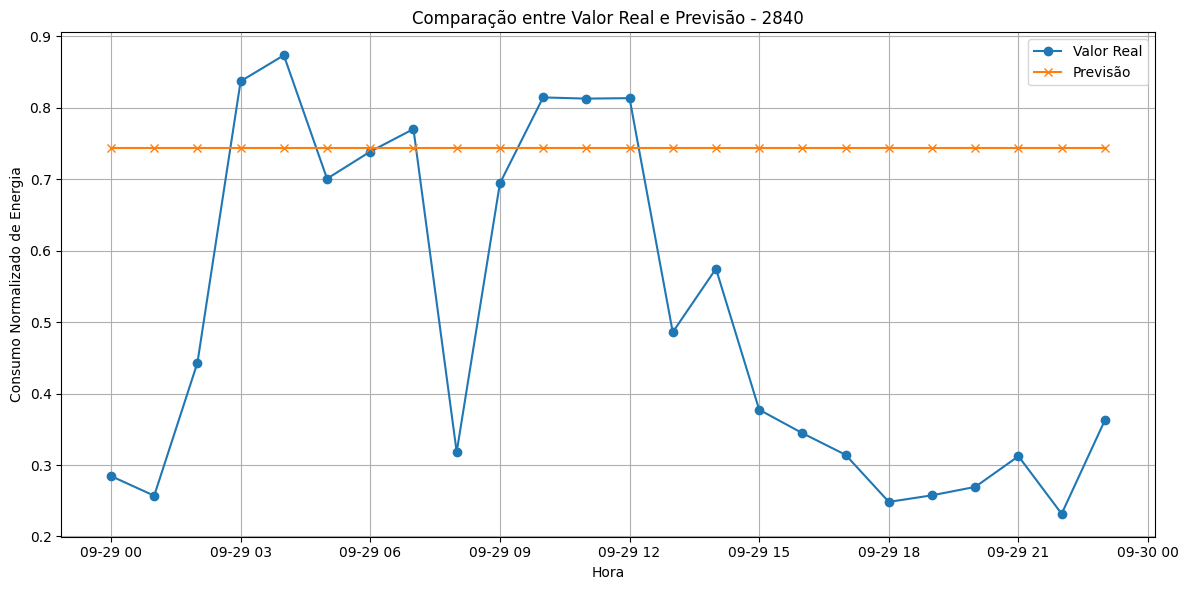

In [38]:
import matplotlib.pyplot as plt

# Criação da figura
plt.figure(figsize=(12, 6))

# Linha dos valores reais
plt.plot(real_values.index, y_true, label="Valor Real", marker='o')

# Linha dos valores previstos
plt.plot(real_values.index, y_pred, label="Previsão", marker='x')

# Título e eixos
plt.title("Comparação entre Valor Real e Previsão - 2840")
plt.xlabel("Hora")
plt.ylabel("Consumo Normalizado de Energia")

# Legenda, grelha e layout
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar gráfico
plt.show()

C:\Users\Alice Dias\AppData\Local\Temp\ipykernel_1908\42556498.py:16: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Alice Dias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


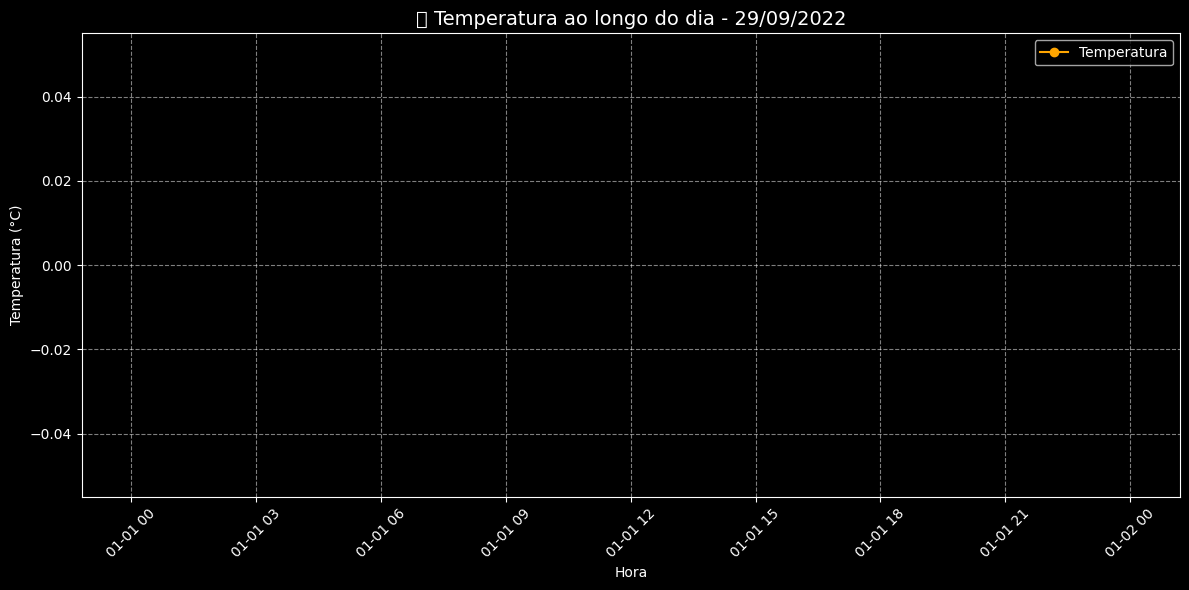

In [39]:
import matplotlib.pyplot as plt

# Filtrar os dados para o dia 29 de setembro de 2022
df_temp_29_set = df_cp.loc["2022-09-29 00:00":"2022-09-29 23:00"]

# Plot
plt.style.use("dark_background")
plt.figure(figsize=(12, 6))
plt.plot(df_temp_29_set.index, df_temp_29_set["Temperature"], marker='o', color='orange', label="Temperatura")
plt.title("📈 Temperatura ao longo do dia - 29/09/2022", fontsize=14)
plt.xlabel("Hora")
plt.ylabel("Temperatura (°C)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
